Height is 4046, and width is 9216


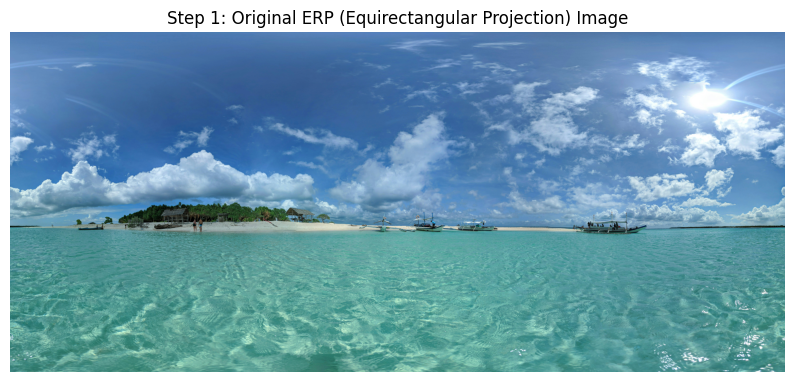

In [ ]:
# ======================================
# 360° ERP Image → Spherical Projection Pipeline
# Steps 1–5
# ======================================

# STEP 1: Add and display image

# from google.colab import files

from IPython.display import Image as ColabImage
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math

# Upload ERP image (e.g., Ocean360Picture.jpg)

# uploaded = files.upload()
# filename = list(uploaded.keys())[0]
# ColabImage(filename)

filename = "Ocean360Picture.jpg"

# Read image in RGB format
erp = cv2.imread(filename)
erp = cv2.cvtColor(erp, cv2.COLOR_BGR2RGB)
H, W, _ = erp.shape

print(f"Height is {H}, and width is {W}")

plt.figure(figsize=(10,5))
plt.imshow(erp)
plt.title("Step 1: Original ERP (Equirectangular Projection) Image")
plt.axis("off")
plt.show()

In [2]:
# Unlike simply slicing a rectangular region from the original ERP image, which causes distortion
# (especially near the poles), this method defines each tile directly on the sphere using uniform
# latitude and longitude steps.  
# 
# It also differs from a forward approach where each ERP pixel is projected to the sphere and
# then back to ERP for each tile, which is more complex and can leave gaps.  
# 
# Here, each tile pixel is reverse-mapped to fractional coordinates in the original ERP image and
# sampled using interpolation. This ensures angular uniformity, reduces distortion, and produces
# rectified tiles that accurately represent the spherical surface.

widthDegree = 20
heightDegree = 20

num_lon_tiles = int(360 / widthDegree)  # 18
num_lat_tiles = int(180 / heightDegree)  # 9

# we first decide on our tile width and derive height from it

tileWidth = int(round(W / num_lon_tiles))
tileHeight = int(round(H / num_lat_tiles))

# tileWidth = int(W / num_lon_tiles)
# tileHeight = int(round((H/W * tileWidth)))

print(f"Wdith will be {tileWidth}, height will be {tileHeight}")

# this will be the array of new tiles, where instead of each element being a list of pixels, its the actual image. same indices though
finalTiles = [[None for _ in range(num_lon_tiles)] for _ in range(num_lat_tiles)]

# === Step 5: Loop over each tile (lat × lon grid) ===
for lat_i in range(num_lat_tiles):
    # Latitude boundaries for this tile
    lat_max = 90.0 - lat_i * heightDegree    # top edge (starts from +90° at north pole)
    lat_min = lat_max - heightDegree         # bottom edge, go a single step down

    # this returns an array of specific latitude values, where length of array equals tileHeight. Basically, for each
    # pixel, we get the corresponding lattitude.
    lat_vals = np.linspace(lat_max, lat_min, tileHeight)

    # now, loop through each longitude (horizontally). Now can actually access each tile
    for lon_j in range(num_lon_tiles):
        
        # Longitude boundaries for this tile
        lon_min = lon_j * widthDegree - 180.0
        # to get max, go one stepi n this direction
        lon_max = lon_min + widthDegree

        # Uniform sampling horizontally: left to right. For each pixel, we get the corresponding longitude
        lon_vals = np.linspace(lon_min, lon_max, tileWidth)

        # === Step 7: Convert lat/lon → ERP pixel coordinates. Note these will be fractions. You're basically sampling parts of the sphere and projecting them, rather than
        # projecting the original pixels.
        # erp_x and erp_y as 1D vectors
        erp_x_vec = (lon_vals + 180.0) / 360.0 * (W - 1)   # shape: (tileWidth,)
        erp_y_vec = (90.0 - lat_vals) / 180.0 * (H - 1)    # shape: (tileHeight,)

        # broadcast to 2D arrays on the fly. We need to do this basically because cv2.remap expects a 2D matrix for each map, which is used for say
        # non rectangular tilling or sampling where map_x and map_y aren't of the same dimesnion, so kinda non uniform sampling. However since we do
        # do it uniformly, we can keep it a vector up until the point we pass it into our model. It's basically expecting a matrix where say for map_x,
        # map_x[i][j] is at horizontal pixel x and veftical pixel j, what's the longitude. Or after beign converted, what's the fracitonal decimal point  corresponging
        # to that longitude in the original image. Same idea with map_y

        # np.tile repeats the vector into multiple rows. So copies current row tileHeight times.

        # np.repeat changes it so that each value in the inner vector is the same, but now each row has a different number
        # from the other rows. By repeating across axis 1, means we repeat each inner vector
        map_x = np.tile(erp_x_vec, (tileHeight, 1)).astype(np.float32)  # (tileHeight, tileWidth)
        map_y = np.repeat(erp_y_vec[:, np.newaxis], tileWidth, axis=1).astype(np.float32)

        # Each output pixel tile_img[i,j] samples the original ERP at coordinates (map_x[i,j], map_y[i,j]).
        # map_x and map_y are floating-point, so remap uses interpolation to compute the pixel value.
        # BORDER_WRAP ensures horizontal wrapping at longitude ±180°, preserving continuity in 360° images.

        tile_img = cv2.remap(
            erp, map_x, map_y,
            interpolation=cv2.INTER_LINEAR,
            borderMode=cv2.BORDER_WRAP
        )

        # Save this tile
        finalTiles[lat_i][lon_j] = tile_img

        # Optional: visualize the first few tiles
        # plt.figure(figsize=(4, 2))
        # plt.imshow(tile_img)
        # plt.title(f"Tile lat:{lat_i} lon:{lon_j}")
        # plt.axis("off")
        # plt.show()


Wdith will be 512, height will be 450


Reconstructed ERP shape: (4050, 9216, 3)


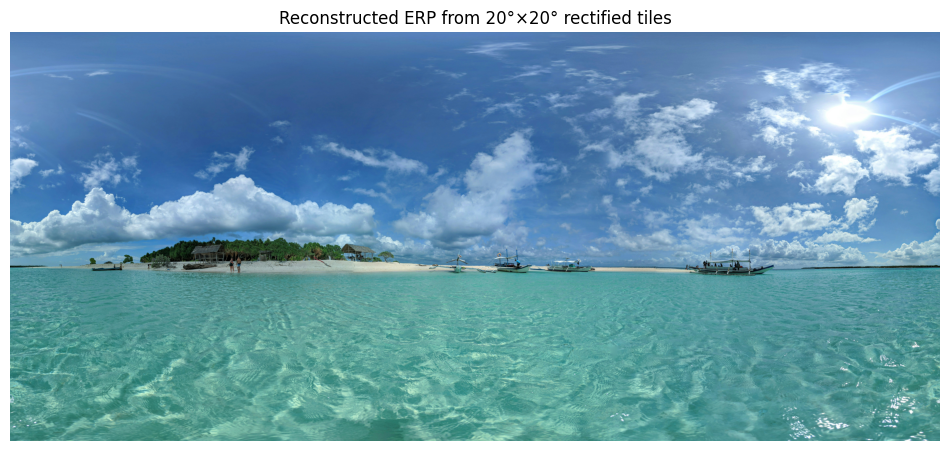

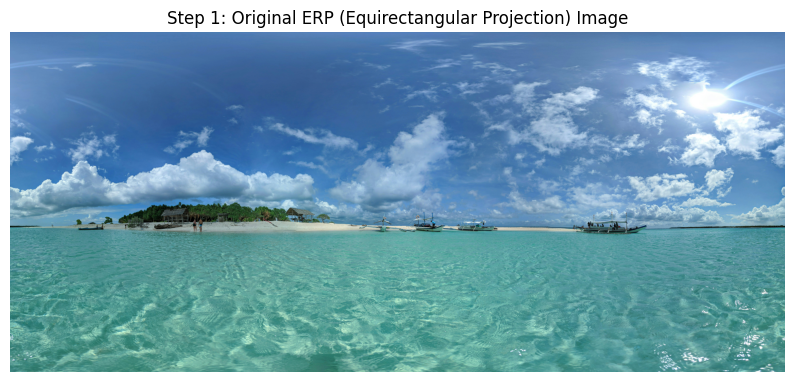

In [4]:
# === Step 9: Combine tiles back into a single ERP-like image ===

rows_combined = []
for lat_i in range(num_lat_tiles):
    # Stack all longitude tiles in this latitude row
    row_tiles = finalTiles[lat_i]
    row_img = np.hstack(row_tiles)
    rows_combined.append(row_img)

# Stack all latitude rows vertically (north → south)
erp_reconstructed = np.vstack(rows_combined)

print("Reconstructed ERP shape:", erp_reconstructed.shape)

plt.figure(figsize=(12, 6))
plt.imshow(erp_reconstructed)
plt.title("Reconstructed ERP from 20°×20° rectified tiles")
plt.axis("off")

plt.figure(figsize=(10,5))
plt.imshow(erp)
plt.title("Step 1: Original ERP (Equirectangular Projection) Image")
plt.axis("off")
plt.show()
